# Anomaly detection

We'll demonstrate how an autoencoder can be used to determine anomalies in electrocardiograms.

_Disclaimer: This application is built for demonstration purposes only. It is not intended for use in any medical setting._

## The ECG dataset

I will use the ECG dataset, which contains 4998 examples of electrocardiogram (ECG) signals. The dataset is available for download as a csv file either at http://www.timeseriesclassification.com/description.php?Dataset=ECG5000 or via the Google cloud storage http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv. 
I will use the latter direction to get the dataset. 

In [2]:
import pandas as pd  

dataframe = pd.read_csv(
    "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv",
    header=None,
)
raw_data = dataframe.values

print(f"Size = {raw_data.shape}")

Size = (4998, 141)


Each ECG trace has 140 points, plus one last datapoint that represents the label ('0' for anomalous and '1' for normal).
I will separate the labels from the actual traces. I will cut out the beginning and the end of the traces so that they can be used with the autoencoder architecture that I will define later. 
Last, I will randomly split the dataset into training (70%) and test (30%). 


In [3]:
from sklearn.model_selection import train_test_split

ecgs = raw_data[:, 2:-11]  ### Why cutting the data?
labels = raw_data[:, -1].astype(bool)

train_ecgs, test_ecgs, train_labels, test_labels = train_test_split(
    ecgs, labels, test_size=0.3,
)

In [15]:
import deeptrack as dt
import numpy as np
import torch

#dt.config.disable_image_wrapper()

def pick_random_ecg(ecgs):
    """Pick a random ECG."""
    return ecgs[np.random.randint(0, ecgs.shape[0])]

training_pipeline = (
    dt.Value(normal_train_ecgs)
    >> pick_random_ecg
    >> dt.Unsqueeze(0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

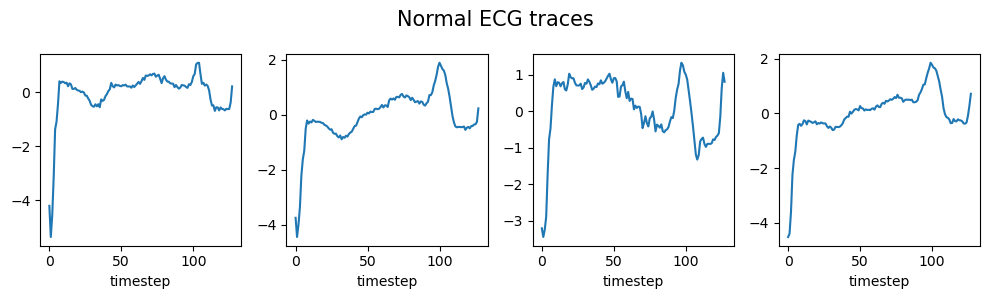

In [16]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=((10, 3)))
fig.suptitle("Normal ECG traces", fontsize=15)
for ax in axs.ravel():
    training_pipeline.update()
    ecg = training_pipeline()
    ax.plot(ecg.squeeze())
    ax.set_xlabel("timestep")

fig.tight_layout()
plt.show()

To use the ECG dataset for anomaly detection purposes, I first need to select only the _normal_ traces and preprocess them. I will rescale them from the original range by subtracting the value corresponding to the minimum and dividing them by the range between the maximum and the minimum. In this way, the data points will be in the range $[0,1]$. Using global values to normalize the data helps to preserve relative information between traces. I thus define a pipeline that performs these procedures on randomly picked traces.


In [17]:
import deeptrack as dt
import numpy as np
import torch

#dt.config.disable_image_wrapper()

normal_train_ecgs = train_ecgs[train_labels]
normal_train_labels = train_labels[train_labels]

min_normal_ecgs = np.min(normal_train_ecgs)
max_normal_ecgs = np.max(normal_train_ecgs)

def pick_random_ecg(ecgs):
    """Pick a random ECG."""
    return ecgs[np.random.randint(0, ecgs.shape[0])]

training_pipeline = (
    dt.Value(normal_train_ecgs)
    >> pick_random_ecg
    >> dt.Subtract(min_normal_ecgs)
    >> dt.Divide(max_normal_ecgs - min_normal_ecgs)
    >> dt.Unsqueeze(0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

I will visualize some of the traces of the dataset after preprocessing.

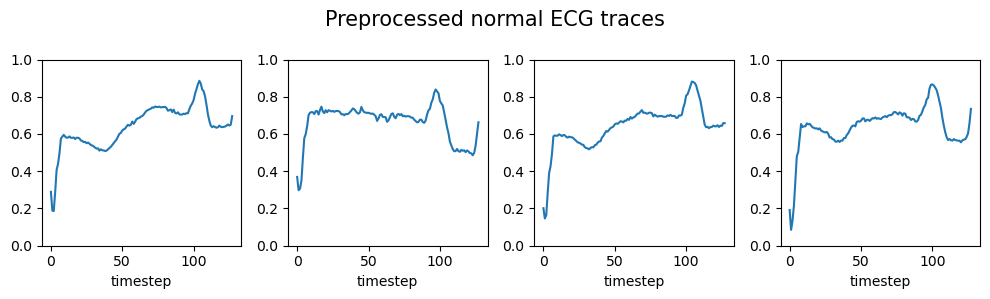

In [18]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=((10, 3)))
fig.suptitle("Preprocessed normal ECG traces", fontsize=15)
for ax in axs.ravel():
    training_pipeline.update()
    ecg = training_pipeline()
    ax.plot(ecg.squeeze())
    ax.set_ylim([0, 1])
    ax.set_xlabel("timestep")

fig.tight_layout()
plt.show()

## Autoencoder
I will train a convolutional autoencoder to reconstruct only normal ECG traces by minimizing the reconstruction error. 
The autoencoder's latent space is ideally kept at a low dimensionality to focus on capturing the most salient features while suppressing less relevant or noisy information.

I implement a simple convolutional autoencoder in 1D using as a backbone the `ConvolutionalEncoderDecoder2d` of `deeplay`.
<!-- A similar exercise, using a dense autoencoder can be found at \href{https://www.tensorflow.org/tutorials/generative/autoencoder}. -->

In [20]:
import deeplay as dl
from torch.nn import Identity
import torch.nn as nn

autoencoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1,
    encoder_channels=[8, 8],
    decoder_channels=[8, 8],
    out_channels=1,
    out_activation=Identity,
)
autoencoder.encoder.blocks.layer.configure(
    nn.Conv1d, kernel_size=4, padding="same"
)
autoencoder.encoder.blocks.pool[1:].configure(
    nn.MaxPool1d, kernel_size=4, stride=4
)
autoencoder.decoder.blocks.layer.configure(
    nn.Conv1d, kernel_size=4, padding="same"
)
autoencoder.decoder.blocks.upsample[:-1].configure(
    nn.ConvTranspose1d, kernel_size=4, stride=4
)

print(autoencoder)

ConvolutionalEncoderDecoder2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv1d](in_channels=1, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=8)
      )
      (1-2): 2 x PoolLayerActivationNormalization(
        (pool): Layer[MaxPool1d](kernel_size=4, stride=4)
        (layer): Layer[Conv1d](in_channels=8, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=8)
      )
    )
    (postprocess): Layer[Identity]()
  )
  (decoder): ConvolutionalDecoder2d(
    (preprocess): Layer[Identity]()
    (blocks): LayerList(
      (0-1): 2 x LayerActivationNormalizationUpsample(
        (layer): Layer[Conv1d](in_channels=8, out_channels=8, kernel_size=4, stride=1, padding=same)
        (activ

We will train the model by minimizing the reconstruction error through the L1 loss,

In [21]:
from torch.nn import L1Loss

regressor_template = dl.Regressor(
    model=autoencoder, loss=L1Loss(), optimizer=dl.Adam(),
)
autoencoder_regressor = regressor_template.create()

We define the dataset and the dataloader. We train for 30 epochs with a batch size of 16. 

In [22]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(
    training_pipeline & training_pipeline,
    length=len(normal_train_ecgs),
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

autoencoder_trainer = dl.Trainer(max_epochs=30, accelerator="auto")

autoencoder_trainer.fit(autoencoder_regressor, train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                          | Params
----------------------------------------------------------------
0 | loss          | L1Loss                        | 0     
1 | train_metrics | MetricCollection              | 0     
2 | val_metrics   | MetricCollection              |

Training: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391828777/work/aten/src/ATen/native/Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


We show a few reconstructed traces together with the model input. The trained model has learned the main features of the normal traces, whereas is not able to generalize to anomalous traces, offering a poor reconstruction. It can also be observed that the reduced number of weights used by the model also produces reconstructed traces that are very similar among them, with only subtle differences. 


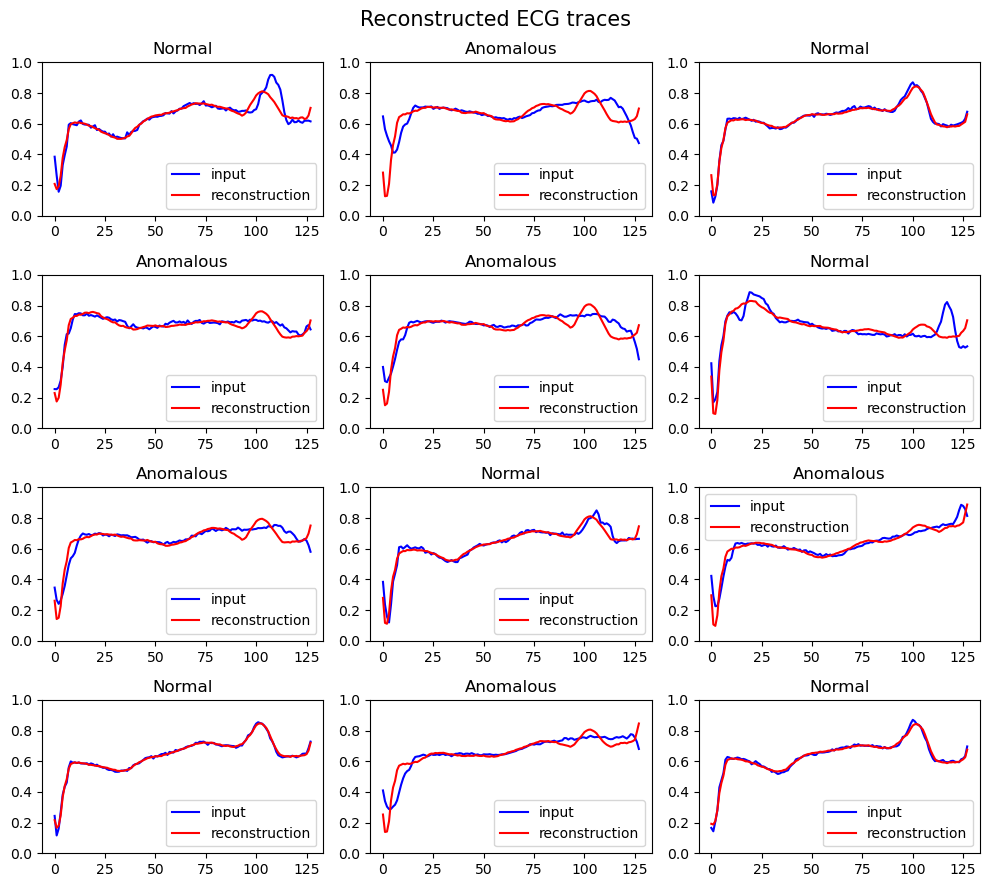

In [25]:
class_label = ["Anomalous", "Normal"]

fig, axs = plt.subplots(4, 3, figsize=((10, 9)))
fig.suptitle("Reconstructed ECG traces", fontsize=15)
for i in range(12):
    ind = np.random.randint(0, test_labels.shape[0])
    input_trace = ((test_ecgs[ind, :] - min_normal_ecgs) 
                   / (max_normal_ecgs - min_normal_ecgs))
    input_label = int(test_labels[ind])
    predicted_trace = autoencoder_regressor(
        torch.tensor(input_trace).float().unsqueeze(0)
    )
    axs[i // 3, i % 3].set_title("{}".format(class_label[input_label]))
    axs[i // 3, i % 3].plot(input_trace, c="b", label="input")
    axs[i // 3, i % 3].plot(
        predicted_trace.detach().squeeze(), c="r", label="reconstruction"
    )
    axs[i // 3, i % 3].set_ylim([0, 1])
    axs[i // 3, i % 3].legend()

fig.tight_layout()
plt.show()

## Anomaly detection

The distribution of the reconstruction metrics obtained for the training dataset can be used to calculate a threshold (e.g., the 90% quantile) to discriminate between normal and anomalous traces based on the reconstruction error. 


/var/folders/hq/wmcbgp7s56b98c9mjf167rz40000gn/T/ipykernel_24753/859078451.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391828777/work/torch/csrc/utils/tensor_new.cpp:264.)
  torch.tensor([(train_d - min_normal_ecgs) / (max_normal_ecgs - min_normal_ecgs) for train_d in normal_train_ecgs])


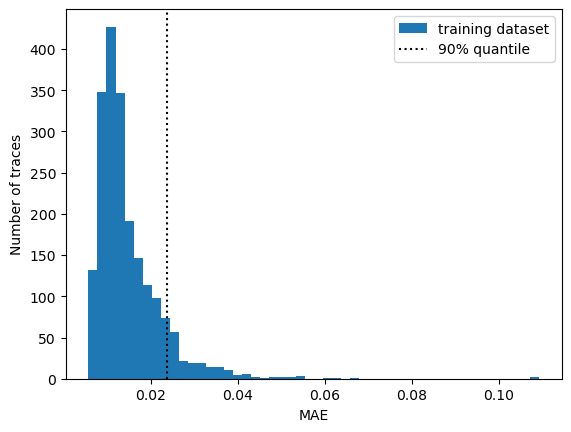

In [26]:
from torch.nn.functional import l1_loss

train_set = (
    torch.tensor([(train_d - min_normal_ecgs) / (max_normal_ecgs - min_normal_ecgs) for train_d in normal_train_ecgs])
    .float()
    .unsqueeze(1)
)
train_set_labels = normal_train_labels

predictions = autoencoder_regressor(train_set).detach()
loss_train = [l1_loss(t, p) for t, p in zip(train_set, predictions)]

th = np.quantile(loss_train, 0.9)

plt.hist(loss_train, bins=50, label="training dataset")
plt.axvline(x=th, color="k", linestyle=":", label="90% quantile")
plt.xlabel("MAE")
plt.ylabel("Number of traces")
plt.legend()
plt.show()

We'll calculate th reconstruction error on the test dataset. We observe a bimodal distribution with a second peak at values larger than the threshold we have calculated from the training dataset. These values should mainly correspond to anomalous traces that have been poorly reconstructed.

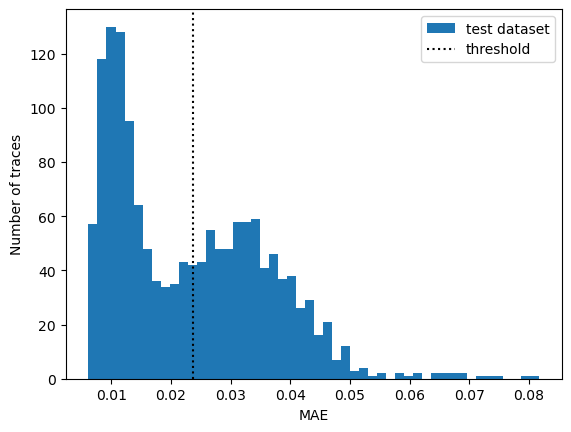

In [27]:
test_set = (
    torch.tensor([(test_d - min_normal_ecgs) / (max_normal_ecgs - min_normal_ecgs) for test_d in test_ecgs]).float().unsqueeze(1)
)
test_set_labels = test_labels

predictions = autoencoder_regressor(test_set).detach()
loss_test = [l1_loss(t, p) for t, p in zip(test_set, predictions)]

plt.hist(loss_test, bins=50, label="test dataset")
plt.axvline(x=th, color="k", linestyle=":", label="threshold")
plt.xlabel("MAE")
plt.ylabel("Number of traces")
plt.legend()
plt.show()

We will classify the traces of the test dataset based on the threshold value and calculate several classification metrics, such as the accuracy, the precision, and the recall. 

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

pred_labels = loss_test < th

print("Accuracy = {}".format(accuracy_score(test_set_labels, pred_labels)))
print("Precision = {}".format(precision_score(test_set_labels, pred_labels)))
print("Recall = {}".format(recall_score(test_set_labels, pred_labels)))

Accuracy = 0.9213333333333333
Precision = 0.9592592592592593
Recall = 0.9013921113689095


## Latent space-based anomaly detection

We apply the model to get the intermediate outputs of both the training and the test datasets.

In [29]:
latent_space_train = autoencoder_regressor.model.encoder(train_set).detach()
latent_space_test = autoencoder_regressor.model.encoder(test_set).detach()

latent_space_train = latent_space_train.view(latent_space_train.shape[0], -1)
latent_space_test = latent_space_test.view(latent_space_test.shape[0], -1)

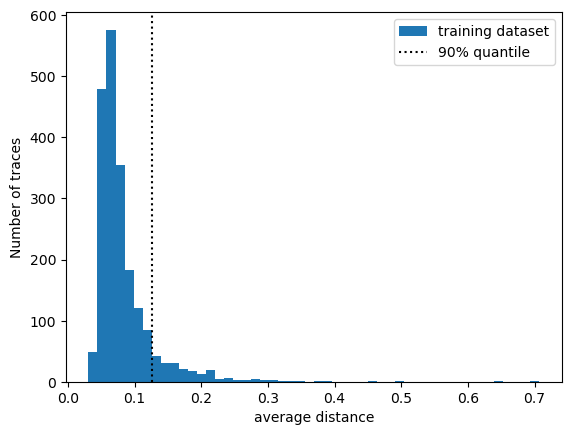

In [30]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 4

nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, algorithm="ball_tree").fit(
    latent_space_train
)
distances, _ = nbrs.kneighbors(latent_space_train)
distances = distances[:, 1:]
m_dist = np.mean(distances, 1)

th = np.quantile(m_dist, 0.9)

plt.hist(m_dist, bins=50, label="training dataset")
plt.axvline(x=th, color="k", linestyle=":", label="90% quantile")
plt.xlabel("average distance")
plt.ylabel("Number of traces")
plt.legend()
plt.show()

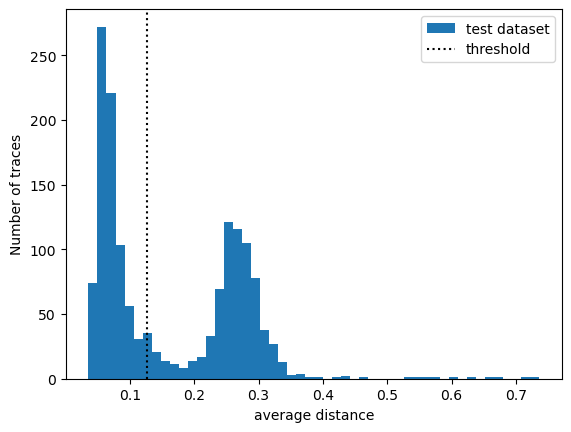

In [31]:
from sklearn.metrics import pairwise_distances

m_dist_test = pairwise_distances(latent_space_test, latent_space_train)
m_dist_test = np.mean(
    np.partition(m_dist_test, n_neighbors, axis=1)[:, :n_neighbors], 1
)

plt.hist(m_dist_test, bins=50, label="test dataset")
plt.axvline(x=th, color="k", linestyle=":", label="threshold")
plt.xlabel("average distance")
plt.ylabel("Number of traces")
plt.legend()
plt.show()

In [32]:
predictions = np.ones_like(test_set_labels)
predictions[m_dist_test > th] = 0

print("Accuracy = {}".format(accuracy_score(test_set_labels, predictions)))
print("Precision = {}".format(precision_score(test_set_labels, predictions)))
print("Recall = {}".format(recall_score(test_set_labels, predictions)))

Accuracy = 0.934
Precision = 0.9935316946959897
Recall = 0.8909512761020881
